In [25]:
path_results = "../datasets/2023-01-01_benchmark_results/main/results.BERT-RBP.csv.gz"
path_config_viz = "../config/visualization.yaml"
path_output_dir = "./"
export = True


# Forewords

From exploration of the full set of results, we identified BERT-RBP as
a method performing unexpectedly bad for many models.

We want to show this here in more details.

# Imports


/home/lambertmoy/projects/Benchmark-RBP/analyses/code/figure_layouts.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


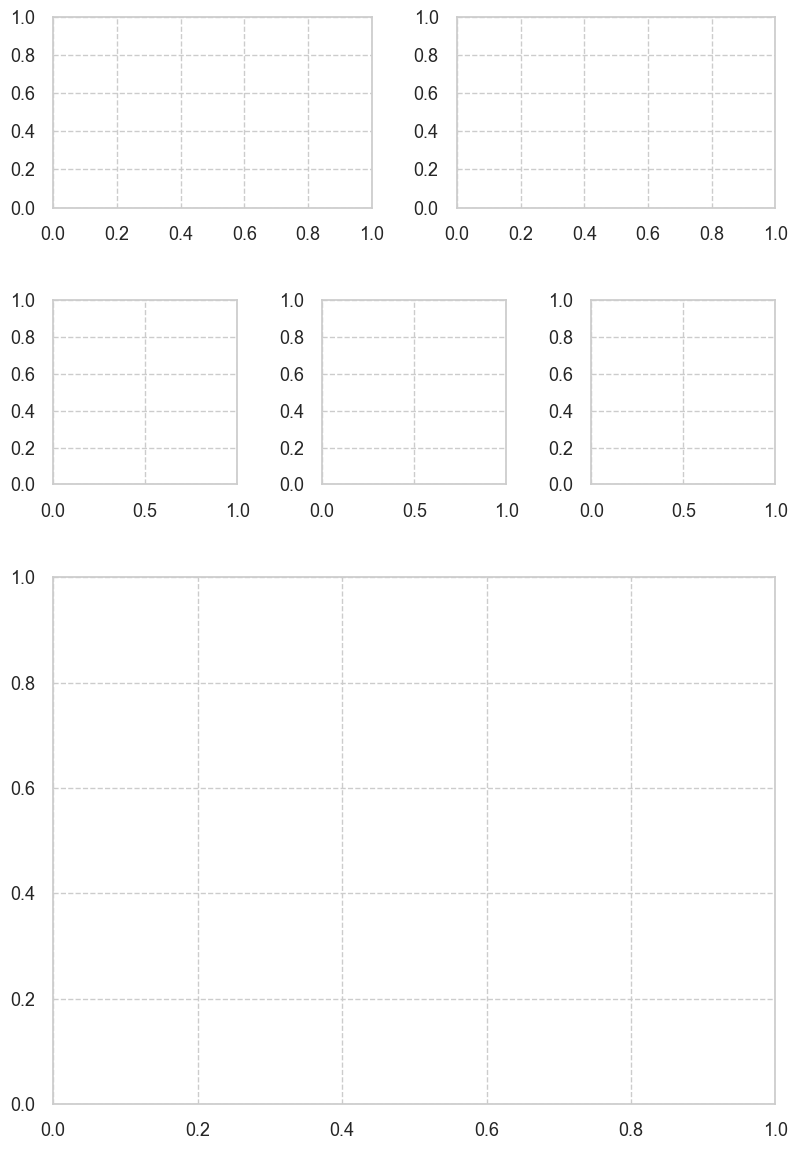

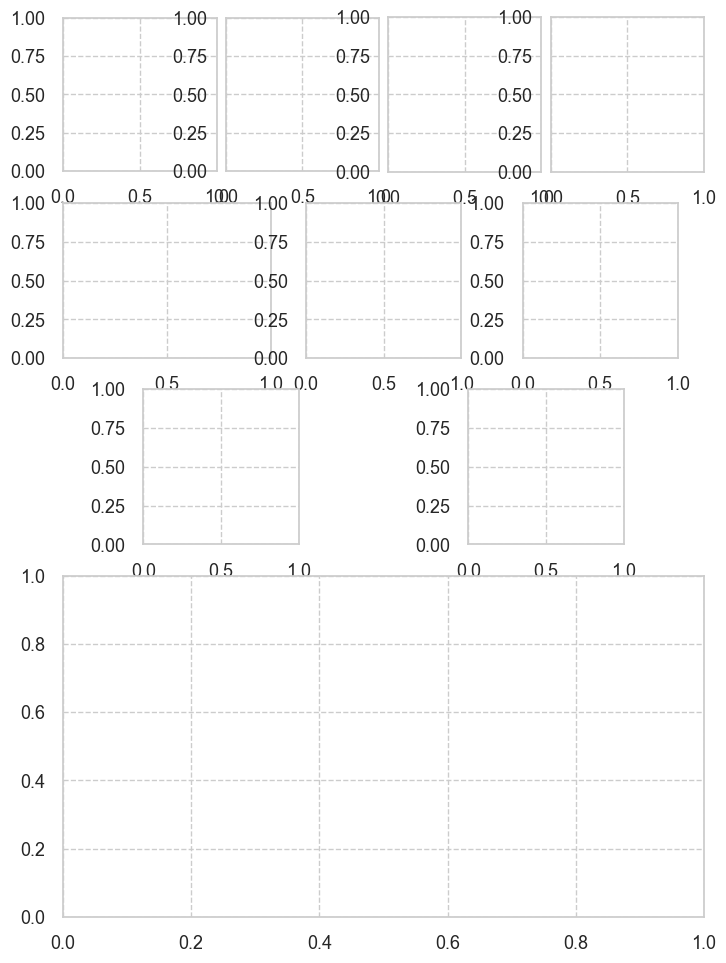

In [3]:
import os
import sys
from pathlib import Path

import pandas as pd
import polars as pl
import numpy as np
import yaml
import scipy.stats

from dotmap import DotMap


path = "../code/"
if not str(path) in sys.path:
    sys.path.insert(0, str(path))

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from plotting_config import *
from local_code import *

%run "../code/plotting_config.py"
%run "../code/figure_layouts.py"

# Load

## Data

In [4]:
columns = [
    "model",
    "dataset",
    "RBP_dataset",
    "fold",
    "model_negativeset",
    "sample",
    "prediction",
    "true_class",
]

df = pd.read_csv(path_results, header=None, index_col=None, names=columns)

In [11]:
grouping = ['dataset','RBP_dataset','fold','model_negativeset']
results_arch = []
for group, group_df in df.groupby(grouping):
    meta_info = dict(zip(grouping, group))
    parsed_df = parse_df(group_df, meta_info)
    results_arch.append(parsed_df)


auroc_table = pd.DataFrame([
                pd.Series(
                    {
                        **{'auroc':get_auroc(ann_df.df),
                            'arch':"BERT-RBP"},
                        **ann_df.meta
                    }) 
                for ann_df in results_arch 
                ])


summarized_table = pd.DataFrame([
                    pd.Series(
                        {
                            **ann_df.meta,
                            **summarize_preds(ann_df.df).to_dict()
                        }) 
                    for ann_df in results_arch
                    ])

In [13]:
print(summarized_table.shape[0])

604


In [12]:
print(df["dataset"].unique())
print(df["RBP_dataset"].unique().shape[0])


['ENCODE' 'Mukherjee-PAR-CLIP' 'iONMF']
302


## Config

In [7]:
with open(path_config_viz, "r") as in_f:
    config_viz = yaml.load(in_f, Loader=yaml.SafeLoader)


DATASETS_COLORS = config_viz["datasets"]["colors"]
DATASETS_dotshape = config_viz["datasets"]["shape"]
arch_colors = config_viz["methods"]["colors"]


# Explore

## Plots

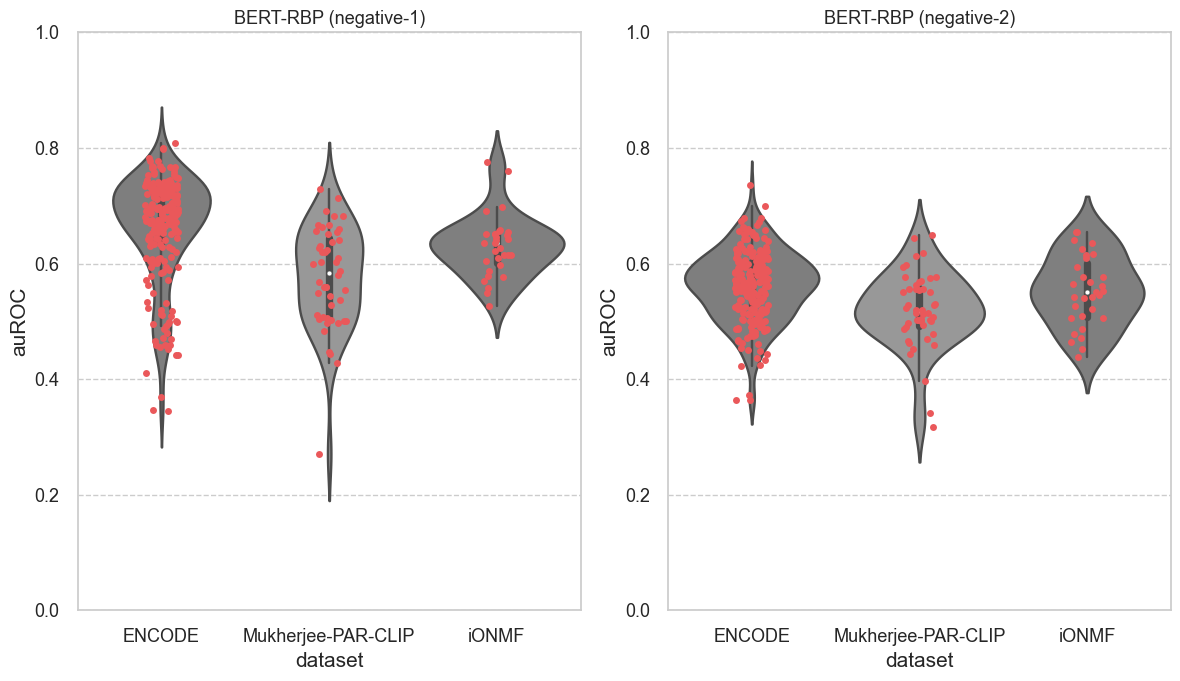

In [27]:
from matplotlib.colors import to_rgba


fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2, sharey=ax1)

sns.violinplot(
    data=auroc_table.loc[lambda df: df['model_negativeset']=='negative-1'],
    x="dataset",
    y="auroc",
    #inner=None,
    saturation=0,
    ax=ax1,
)
#for violin in ax1.collections:
#    violin.set_facecolor("#BBBBBB", alpha=0.0)

sns.stripplot(
    data=auroc_table.loc[lambda df: df['model_negativeset']=='negative-1'],
    x="dataset",
    y="auroc",
    color=arch_colors["BERT-RBP"],
    ax=ax1,
)

ax1.set_ylim(0,1)
ax1.set_ylabel("auROC")
ax1.set_title("BERT-RBP (negative-1)")

sns.violinplot(
    data=auroc_table.loc[lambda df: df['model_negativeset']=='negative-2'],
    x="dataset",
    y="auroc",
    #inner=None,
    saturation=0,
    ax=ax2,
)
#for violin in ax1.collections:
#    violin.set_facecolor("#BBBBBB", alpha=0.0)

sns.stripplot(
    data=auroc_table.loc[lambda df: df['model_negativeset']=='negative-2'],
    x="dataset",
    y="auroc",
    color=arch_colors["BERT-RBP"],
    ax=ax2,
)

ax2.set_ylim(0,1)
ax2.set_ylabel("auROC")
ax2.set_title("BERT-RBP (negative-2)")


if export:
    savefig_file = str(Path(path_output_dir) / "BERT-RBP.auroc.violinplot.{EXT}")
    my_savefig(savefig_file)

plt.tight_layout()
plt.show()